<a href="https://colab.research.google.com/github/VicDc/Uruz01/blob/main/7004_Live_Session_11_Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Emotion Recognition Using a Self-made Convolutional Neural Network

## Introduction

Facial Emotion Recognition (FER) is a technology used for sentiment analysis through diverse mediums, such as images and videos, and is categorized under the umbrella of **affective computing**.

 FER explores computers' capabilities to recognize and interpret human emotions. Decoding facial expressions as a form of non-verbal communication has been a longstanding interest in psychology and Human-Computer Interaction. Recent advancements in machine learning, coupled with the widespread availability of cameras, have propelled the development of FER technology. Notably, major corporations like NEC and Google, alongside smaller entities such as Affectiva and Eyeris, have recognized the growing importance of FER and invested significantly in its development.

FER analysis involves two key steps: *face detection* and *emotion classification*. Depending on the algorithm, the facial emotion can be classified into basic emotions (e.g., anger, disgust, fear, joy, sadness, surprise) or compound emotions (e.g., happily sad, happily surprised, happily disgusted, sadly fearful, sadly angry, sadly surprised). Alternatively, facial expressions can be linked to physiological or mental states, such as tiredness or boredom. The increasing involvement of diverse companies underscores the technology's relevance and the intricate process involved in deciphering complex human emotions through facial cues.

FER has been a controversial topic in the definition of the AI Act, being results now a **high-risk** applications.

## Facial Recognition Data for Computer Vision

The analysis of emotions through facial expressions presents challenges to accuracy due to variations among individuals, potential blending of different emotional states, or the absence of any expressed emotion. Additionally, certain emotions may not manifest visibly on a person's face, and relying solely on facial expressions can yield incorrect impressions. Factors contributing to ambiguity include contextual nuances like sarcasm, socio-cultural influences, and technical elements such as varying camera angles, lighting conditions, and facial masking.

We will use a dataset [**Challenges in Representation Learning: Facial Expression Recognition Challenge**](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data). The dataset comprises grayscale images of faces with dimensions of 48x48 pixels. The faces in the dataset are already detected and centered. The goal is to classify hte images into seven distinct categories:
0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The

1.   Angry
2.   Disgust
3.   Fear
4.   Happiness
5.   Sadness
6.   Surprise
7.   Neutral

Tre training set, with 28,709 examples, is detailed in the "train.csv" file, featuring columns for emotion codes (ranging from 0 to 6) and pixel data presented as space-separated values. The "test.csv" file, used for prediction, includes only the pixel column. The dataset was shared for a competition on [Kaggle](https://www.kaggle.com). We will configure the Kaggle API and download the dataset.

In [ ]:
import os

# We configure Kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions to make the file accessible
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')
!rm -rf data
!mkdir data
os.chdir('data')
!pwd



kaggle.json
/content/data


We can now download the dataset. After download it, we will unzip the file. The extracted folder contains the training set and the test set already split. Other files are file needed for the Kaggle competition.

**Note:** when a line in a cell starts with "!", it gives a command directly to the operating system.

In [ ]:
#
!pip install -q kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 99% 281M/285M [00:04<00:00, 63.7MB/s]
100% 285M/285M [00:04<00:00, 68.6MB/s]


In [ ]:
# Unzip data
#!unzip train.csv.zip train.csv
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


### Loading the Data

The downloaded dataset is in *.csv* file format. We load the *train.csv* file and convert it to numeric format into an array. The training images and labels are saved in **x_train** and **y_train** respectively.

In [ ]:
import csv
import numpy

train_images = []
train_labels = []

categories_count = {}

with open('train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


We can visualize the histogram of the emotions present in the dataset.

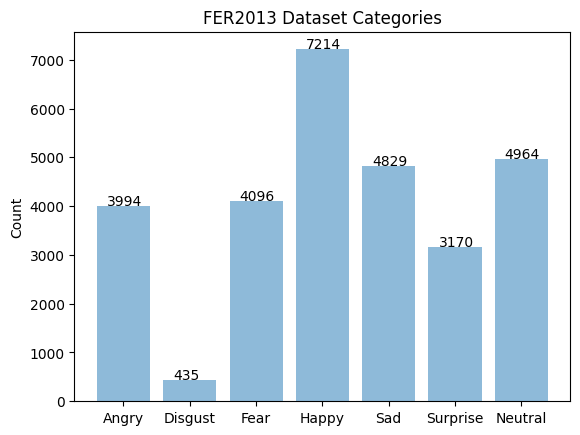

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = numpy.arange(len(categories))

counts = []
for label in range(len(categories)):
    label_str = str(label)
    count = categories_count[label_str]
    counts.append(count)
    plt.text(label - 0.25, count + 15, str(count))

# Draw histogram
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, categories)
plt.ylabel('Count')
plt.title('FER2013 Dataset Categories')

plt.show()

We can visualize the pictures too.

Label is: 0


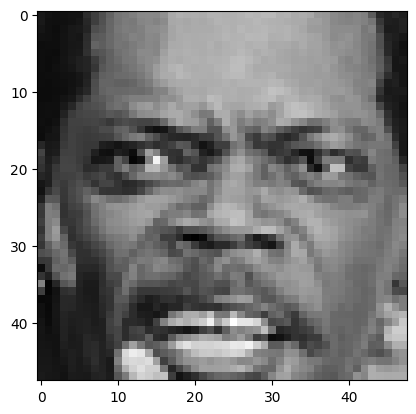

In [ ]:
image = x_train[10]
label = y_train[10]

print('Label is: ' + str(label))
plt.imshow(image, cmap='gray')

### Data Preprocessing

We split the dataset into training set and validation set. We choose 20% of the dataset as validation set, and we can leave the rest for training.

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(len(x_train), 48, 48, 1)
x_test = x_test.reshape(len(x_test), 48, 48, 1)

print(x_train.shape)
print(x_test.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)


## Model Creation and Training

To classify the emotion, we will train a fully connected Convolutinal Neural network. We will use Tensorflow/Keras to create the model and as backend to train the model. We will import all the required packages before the training process.

In [ ]:
import tensorflow as tf

print('Tensorflow version: {}'.format(tf.__version__))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import Model, Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Tensorflow version: 2.17.1


We will refer to the [VGGNet architecture](https://arxiv.org/pdf/1409.1556.pdf), an architecture designed the computer vision applications that uses several stacks of layers. The model will have the following components:
* **Convolutional layers**: These are the building blocks of the architecture, which learn the image features by computing the dot product between the weights and small regions on the image. All the convolutional layers are designed with 3 x 3 kernal size, and several filters.
- **Activation functions**: The activation functions are applied to the outputs of the layers in the network. We use ReLU (Rectified Linear Unit) activation function to increase the non-linearity of the network. Besides, we use Softmax to compute the probability of each category.
- **Pooling layers**: These layers down-sample the image to reduce the spatial data and extract features. In our model, we use Max Pooling with 3 x 3 pooling size and a 2 x 2 stride.
- **Dense layers**: The dense layers are stacked as the fully connected layers of the network, which get the feature data from the previous convolutional layers and perform the final inference.
- **Dropout layers**: The dropout layers are used to prevent over-fitting when training the model.
- **Batch normalization**: This technique can be used to speed up learning by normalizing the output of the previous activation layer.

The diagram of the model is displayed in the picture below.

![cnn](https://drive.google.com/uc?id=1jjORxRgvEDDMLZ-mX5JkCnUWUFn7IHpL).

Our model will have 5 stacks of layers. In each of the first 4 stacks of layers, there are 2 convolutional layer followed by 1 pooling layer. We use batch normalization to speed up training and dropout to prevent over-fitting. At the end of the network. we pile up 3 fully-connected layers, followed by the Softmax activation function, which generates the probability of the facial emotion detected.

We compile our model using Adam optimizer with a certain learning rate. Considering that we are dealing with a multi-class classification problem, we will use `sparse_categorical_crossentropy` as the loss function.

In [ ]:
cnn_model = Sequential()

# 1st convolution layer
cnn_model.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 2nd convolution layer
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 3rd convolution layer
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 4th convolution layer
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# Fully connected layer
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(7, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summary the model
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 10, 10, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,102,791 (19.47 MB)

 Trainable params: 5,098,951 (19.45 MB)

 Non-trainable params: 3,840 (15.00 KB)

We can now train our model. We will use Early Stopping strategy, which will stop the training process when there is no improvement in the validation accuracy. Besides, we will also reduce the learning rate by a specific factor if a plateau is detected in the validation loss.

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

# Train the model
history = cnn_model.fit(x_train,
                        y_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.2183 - loss: 2.0368 - val_accuracy: 0.2586 - val_loss: 1.8283 - learning_rate: 0.0010
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.2790 - loss: 1.7512 - val_accuracy: 0.3265 - val_loss: 1.6242 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.3975 - loss: 1.5344 - val_accuracy: 0.4127 - val_loss: 1.4972 - learning_rate: 0.0010
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.4539 - loss: 1.4219 - val_accuracy: 0.4646 - val_loss: 1.3510 - learning_rate: 0.0010
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4985 - loss: 1.3294 - val_accuracy: 0.4692 - val_loss: 1.3858 - learning_rate: 0.0010
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.5203 - loss: 1.2829 - val_accuracy: 0.5341 - val_loss: 1.2142 - learning_rate: 0.0010
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.5

## Model Evaluation and Improvement

When training is over, we display both the training accuracy and validation accuracy.

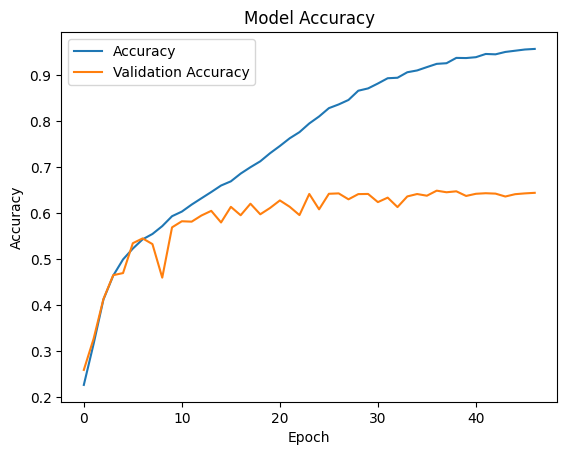

In [ ]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

### Improve Model

We improve our model to increase the validation accuracy trying two strategies:
* Generate hard data
* Data augmentation

Let's evaluate our model on the validation test. Our current accuracy is around 64%.

In [ ]:
# Evaluate the model before improvement
_, score_before_improvement = cnn_model.evaluate(x_test, y_test)
print('Score before improvement: {}'.format(score_before_improvement))

180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6409 - loss: 2.0210
Score before improvement: 0.6436781883239746


We apply the first improvement by generating **hard data**.

Specifically, instead of training the model over and over, we select the images which are incorrectly labelled by the model and train the model on these specific images.

Let's make predictions first, and let's put incorrect predictions into the array of hard data for further training.

In [ ]:
# Generate hard data
hard_images = []
hard_labels = []

# Make predictions
predictions = cnn_model.predict(x_test)
for i, v in enumerate(predictions):
    y_predict = numpy.argmax(v)
    y_real = y_train[i]
    if y_predict != y_real:
        # If predict incorrectly, append to array
        image = x_train[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_hard = numpy.array(hard_images)
y_hard = numpy.array(hard_labels)

print(x_hard.shape)
print(y_hard.shape)

180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
(4736, 48, 48, 1)
(4736,)


We can now train our model on these specific images which were previously incorrectly predicted by our model.

In [ ]:
# Train the model on hard data
x_hard_train, x_hard_test, y_hard_train, y_hard_test = train_test_split(x_hard, y_hard, test_size=0.2)
history = cnn_model.fit(x_hard_train,
                        y_hard_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_hard_test, y_hard_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - accuracy: 0.9625 - loss: 0.1107 - val_accuracy: 0.9905 - val_loss: 0.0244 - learning_rate: 5.9049e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9707 - loss: 0.0892 - val_accuracy: 0.9937 - val_loss: 0.0230 - learning_rate: 5.9049e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9663 - loss: 0.1348 - val_accuracy: 0.9873 - val_loss: 0.0398 - learning_rate: 5.9049e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9706 - loss: 0.0858 - val_accuracy: 0.9842 - val_loss: 0.0359 - learning_rate: 5.9049e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9787 - loss: 0.0693 - val_accuracy: 0.9884 - val_loss: 0.0326 - learning_rate: 5.9049e-04
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9748 - loss: 0.0759 - val_accuracy: 0.9736 - val_loss: 0.1148 - learning_rate: 5.9049e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy

We should be careful that this approach would overfit the model. To avoid overfitting, we train the model on augmented data to diversify our training dataset by rotating, shifting, zooming or flipping the images, which will improve our model by learning more generic features of each image.

In [ ]:
# Perform data augmentation
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
flow = data_generator.flow(x_train,
                           y_train,
                           batch_size=64)

# Train the model again to balance out
history = cnn_model.fit(flow,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.6289 - loss: 1.2314 - val_accuracy: 0.6475 - val_loss: 0.9835 - learning_rate: 4.7830e-04
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.6645 - loss: 0.9890 - val_accuracy: 0.6451 - val_loss: 0.9643 - learning_rate: 4.7830e-04
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.6638 - loss: 0.9707 - val_accuracy: 0.6473 - val_loss: 0.9658 - learning_rate: 4.7830e-04
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.6756 - loss: 0.9482 - val_accuracy: 0.6600 - val_loss: 0.9429 - learning_rate: 4.7830e-04
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6780 - loss: 0.9254 - val_accuracy: 0.6620 - val_loss: 0.9514 - learning_rate: 4.7830e-04
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6780 - loss: 0.9145 - val_accuracy: 0.6684 - val_loss: 0.9319 - learning_rate: 4.7830e-04
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - a

We finally evaluate our model after improvement. The validation accuracy has increased to around **68%**.

If we compare our result to the [Kaggle competition leaderboard](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard), our score can be ranked within the top 5.


In [ ]:
# Evaluate the model after improvement
_, score_after_improvement = cnn_model.evaluate(x_test, y_test)
print('Score after improvement: {}'.format(score_after_improvement))

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6695 - loss: 0.9451
Score after improvement: 0.6664925217628479


## Testing the Model

Let's now make predictions.

We calculate the confusion matrix on the test set.
Since the dataset **did NOT** provide too many images labelled with "Disgust", we notice that the model is not able to classify the images labelled with "Disgust" very well.

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


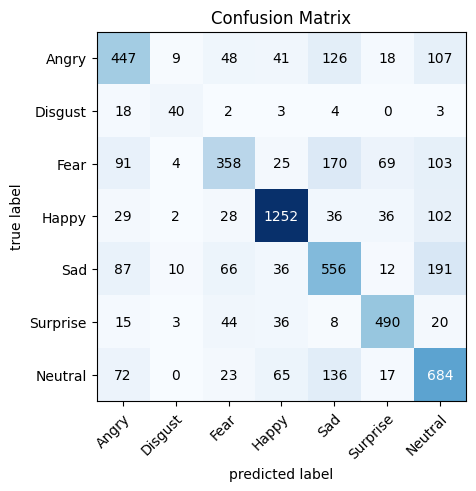

In [ ]:
!pip install -U mlxtend > /dev/null 2>&1

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Make predictions
predictions = cnn_model.predict(x_test)
y_predict = numpy.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Display confusion matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names)
plt.title('Confusion Matrix')
plt.show()

We can test on images outside the test set too.


In [ ]:
# Download into data folder
os.chdir('/content/data')

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ommGLsYSnmX8846iyQigKQfIfvpQzsF0' -O happy.jpg > /dev/null 2>&1
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1I1IjDm9Az4pkDqOz3zcQAguEJ1OsWagt' -O sad.jpg > /dev/null 2>&1
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZLglz_y0QklbYTcwJW1wH0YnAwBn6-1I' -O surprise.jpg > /dev/null 2>&1

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_facial_expression(image_path):
    """Predict facial expression for image"""
    # Open image
    rgb_image = image.load_img(path=image_path,
                            color_mode='grayscale',
                            target_size=(48, 48))
    # Convert to array
    rgb_array = image.img_to_array(rgb_image)
    rgb_array = numpy.expand_dims(rgb_array, axis=0)

    # Show image
    rgb_display = numpy.array(rgb_array, 'float32')
    rgb_display = rgb_display.reshape([48, 48]);
    plt.imshow(rgb_display, cmap='gray')
    plt.show()

    # Make predictions
    rgb_array = rgb_array / 255.0
    prediction = cnn_model.predict(rgb_array)

    # Draw the histogram
    plt.bar(y_pos, prediction[0], align='center', alpha=0.5)
    plt.xticks(y_pos, categories)
    plt.ylabel('Percentage')
    plt.title('Facial Expression Prediction')
    plt.show()

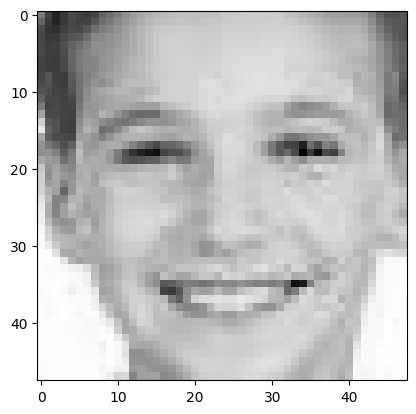

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


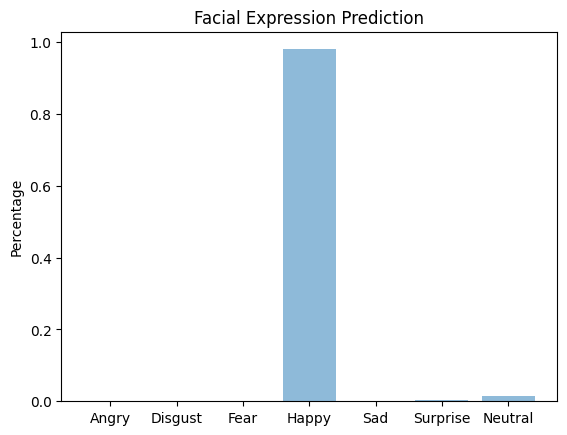

In [ ]:
# Happiness

predict_facial_expression('happy.jpg')

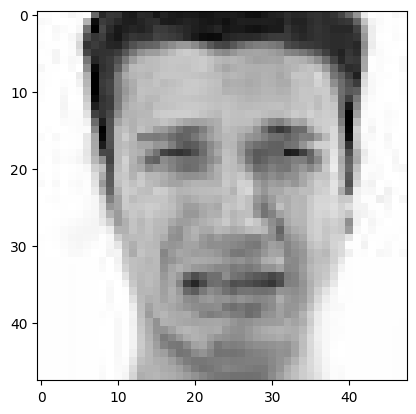

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


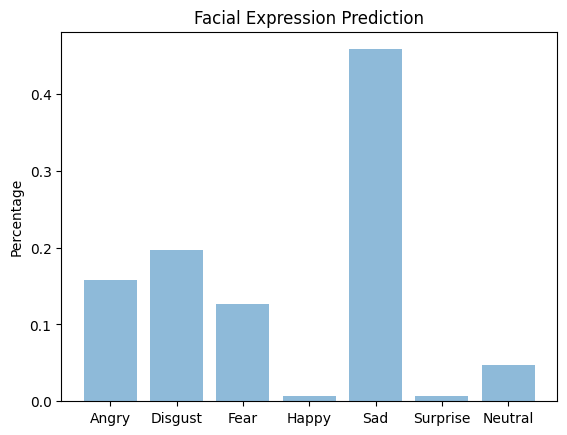

In [ ]:
# Sadness

predict_facial_expression('sad.jpg')

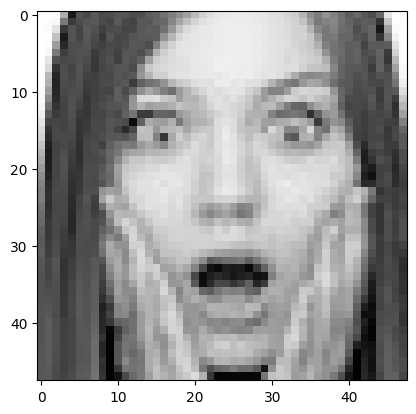

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


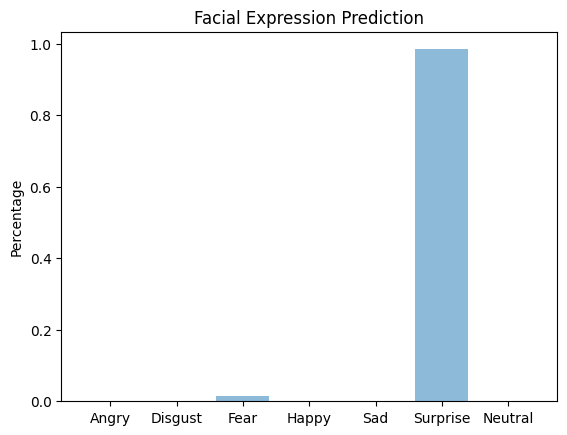

In [ ]:
# Surprise

predict_facial_expression('surprise.jpg')

## Model Export

We finally export the model and we save our model for both TensorFlow and [TensorFlow Lite](https://www.tensorflow.org/lite).

In [ ]:
# Create build folder
os.chdir('/content/')
!rm -rf build
!mkdir build
os.chdir('build')
!pwd

/content/build


In [ ]:
# Save tensorflow model
cnn_model.save('OPIT-EmotionRecognition-FER2024.keras')

In [ ]:
# Save tensorflow lite model
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()
open("OPIT-EmotionRecognition-FER2024.tflite", "wb").write(tflite_model)

Saved artifact at '/tmp/tmp9e6av6cf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  135568196037696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568151645344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568151654496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568151656256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568151653264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568151655024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568150647328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568150645392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568150650496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568150652256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568150649792:

20407784